This notebook shows how the model for IrtyshI, see [Free-form grale lens inversion of galaxy clusters with up to 1000 multiple images](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.3998G/abstract), can be imported as a Grale model. The
cluster itself was modeled using [gravlens/lensmodel](https://www.physics.rutgers.edu/~keeton/gravlens/2012WS/), see also [Keeton 2001](https://ui.adsabs.harvard.edu/abs/2001astro.ph..2341K/abstract)

In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *

cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)
feedback.setDefaultFeedback("none")

z_lens = 0.4

D = cosm.getAngularDiameterDistance
Dd = D(z_lens)

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
def la(l):
    srcAndImg, xArcsec, yArcsec, z = l.split()
    xArcsec, yArcsec, z = map(float, [xArcsec, yArcsec, z])
    src, img = map(int, srcAndImg.split('.'))
    
    return { "x": xArcsec*ANGLE_ARCSEC, "y": yArcsec*ANGLE_ARCSEC, "srcnr": src, "imgnr": img, "z": z}
inputImages = images.readInputImagesFile('images_combined_IrtyshI.dat', isPointImagesFile=True, lineAnalyzer=la)

In [4]:
sources = [ ]
for line in open("sources_IrtyshI.dat", "rt"):
    line = line.strip()
    if not line:
        continue
    srcnum, xpos, ypos, z, mult = list(map(float, line.split()))
    sources.append({"srcnr": int(srcnum), "x": xpos*ANGLE_ARCSEC, "y": ypos*ANGLE_ARCSEC, "z": z})

In [5]:
alpha = 0.5

bScale = ANGLE_ARCSEC**(alpha-2)
lens1 = lenses.AlphaPotLens(Dd, { 
    "b": 26.8954/bScale,
    "alpha": alpha,
    "q": 1.0,
    "K2": 0.35,
    "s": 3.0*ANGLE_ARCSEC
})
lens2 = lenses.AlphaPotLens(Dd, { 
    "b": 26.8954/bScale,
    "alpha": alpha,
    "q": 1.0,
    "K2": -0.25,
    "s": 3.0*ANGLE_ARCSEC
})
lensesAndPositions = [ (lens1, V(-13.05,-14.85)*ANGLE_ARCSEC), (lens2, V(21.75,24.75)*ANGLE_ARCSEC) ]

alpha = 0.45
bScale = ANGLE_ARCSEC**(alpha-2)
for line in open("small_lenses_IrtyshI.dat", "rt"):
    line = line.strip()
    if not line:
        continue
    nr, xpos, ypos, b = list(map(float, line.split()))
    lens = lenses.AlphaPotLens(Dd, {
        "b": b/bScale,
        "alpha": alpha,
        "q": 1.0,
        "K2": 0,
        "s": 3.0*ANGLE_ARCSEC
    })
    lensesAndPositions.append((lens, V(xpos, ypos)*ANGLE_ARCSEC))
    

In [6]:
compositeLensParams = [ { "x": p[0], "y": p[1], "factor":1, "angle": 0, "lens": l} for l, p in lensesAndPositions ]
compLens = lenses.CompositeLens(Dd, compositeLensParams)

In [7]:
li = plotutil.LensInfo(compLens, size=130*ANGLE_ARCSEC, center=[5*ANGLE_ARCSEC,5*ANGLE_ARCSEC], Ds=1, Dds=0.8)

/home/jori/anaconda3-202002/envs/grale2env202002/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


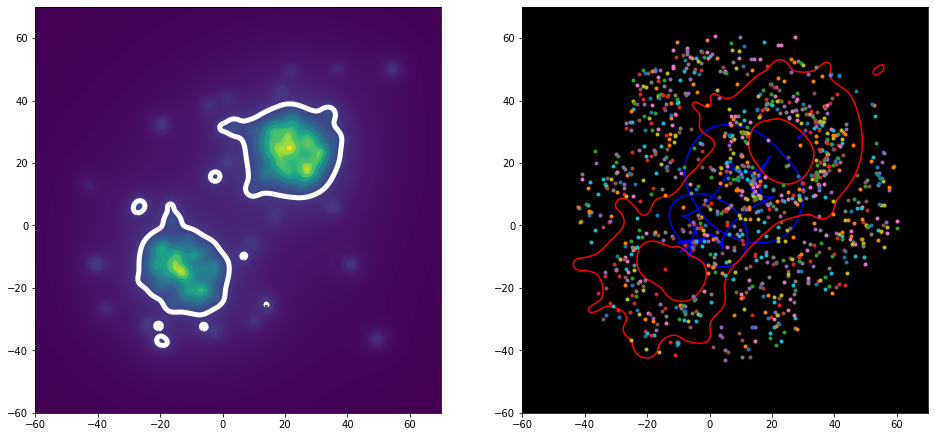

In [8]:
sigmaCrit = compLens.getCriticalDensity(1,1)

plotutil.plotDensityInteractive(li, densityUnit=sigmaCrit)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plotutil.plotDensity(li)
plotutil.plotDensityContours(li, densityUnit=sigmaCrit, linewidths=3)
plotutil.plotDensityContours(li, densityUnit=sigmaCrit, levels=[1], linewidths=5, cmap="gray_r")

plt.subplot(1,2,2)
plotutil.plotImagePlane(li)
plotutil.plotImagesData(inputImages)

In [9]:
iws = inversion.InversionWorkSpace(zLens=0.4, regionSize=20*ANGLE_ARCSEC, 
                                   regionCenter=[2.5*ANGLE_ARCSEC, 2.5*ANGLE_ARCSEC])

for img in inputImages:
    iws.addImageDataToList(img['imgdata'], img['z'], 'pointimages')

In [10]:
bpImages = iws.backProject(compLens)
plt.figure(figsize=(8,8))
plotutil.plotImagesData(bpImages)

sourceX = np.array([ s["x"] for s in sources])
sourceY = np.array([ s["y"] for s in sources])
plt.plot(sourceX/ANGLE_ARCSEC, sourceY/ANGLE_ARCSEC, "x")
plt.gca().set_aspect("equal")

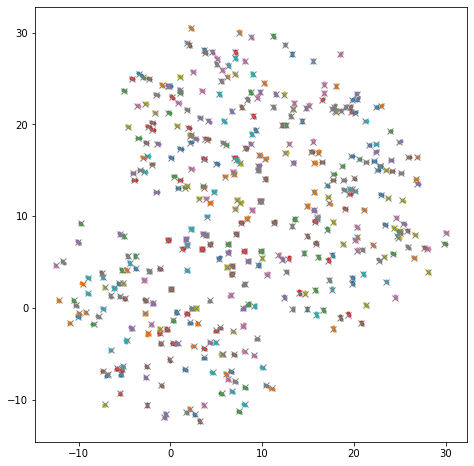

In [11]:
compLens.save("real_irtyshI.lensdata")